<a href="https://colab.research.google.com/github/sahan323/vessel-segmentation/blob/main/vessel_segmentation_unet_vgg19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing Libraries

In [1]:
import torch
import torch.nn as nn
from torchvision.models import vgg19_bn,VGG19_BN_Weights
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Normalize, ToTensor, Compose

import os
import PIL
from PIL import Image


from matplotlib import pyplot as plt
import math
import pandas as pd
import numpy as np

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
print(vgg19_bn())

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [4]:
if torch.cuda.is_available():
    device=torch.device(type="cuda", index=0)
else:
    device=torch.device(type="cpu", index=0)

In [5]:
device

device(type='cuda', index=0)

Image Type: <class 'PIL.TiffImagePlugin.TiffImageFile'>
Mask Type: <class 'PIL.GifImagePlugin.GifImageFile'>
Image Size: (565, 584)
Image Shape: (584, 565, 3) Mask Shape: (584, 565)
Unique in Mask: [  0 255]
Image Data Type: uint8
Mask Data Type: uint8


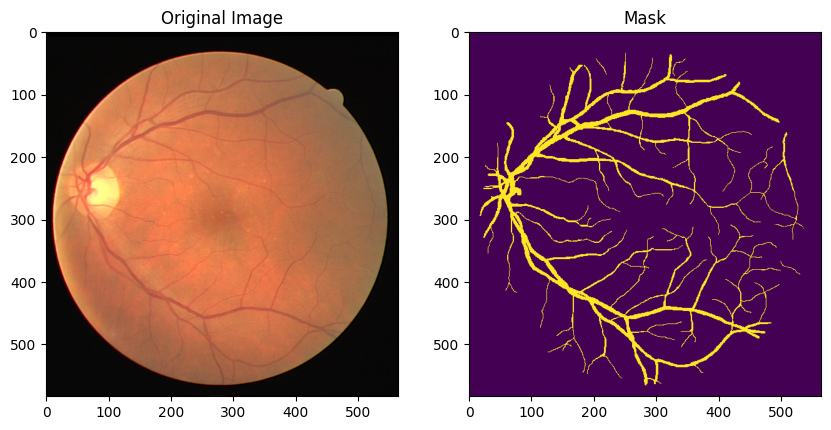

In [6]:
# Load image and mask
img_path = '/content/drive/MyDrive/all/train/21_training.tif'
mask_path = '/content/drive/MyDrive/all/train/21_manual1.gif'
img = Image.open(img_path)
mask = Image.open(mask_path)

# Display types and sizes
print("Image Type:", type(img))
print("Mask Type:", type(mask))
print("Image Size:", img.size)

# Display shapes and unique values
img_array = np.array(img)
mask_array = np.array(mask)
print("Image Shape:", img_array.shape, "Mask Shape:", mask_array.shape)
print("Unique in Mask:", np.unique(mask_array))
print("Image Data Type:", img_array.dtype)
print("Mask Data Type:", mask_array.dtype)

# Display images

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(img_array)
plt.subplot(1, 2, 2)
plt.title("Mask")
plt.imshow(mask_array)
plt.show()


In [7]:
def reshape_to_512(imgpath):
    ori_image = Image.open(imgpath)
    reshaped_image=ori_image.resize((512,512),PIL.Image.NEAREST)

    return reshaped_image

After Reshape:
Image Type: <class 'PIL.Image.Image'>
Mask Type: <class 'PIL.Image.Image'>
Image Shape: (512, 512, 3) Mask Shape: (512, 512) Image dtype: uint8 Mask dtype: uint8
Unique in Mask: [  0 255]
Number of Ones in Mask: 19531.0


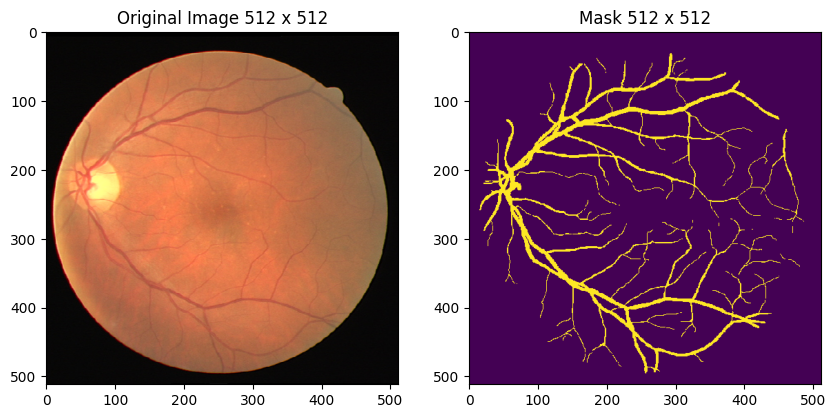

In [9]:
# Reshape images
img = reshape_to_512('/content/drive/MyDrive/all/train/21_training.tif')
mask = reshape_to_512('/content/drive/MyDrive/all/train/21_manual1.gif')

# Display reshaped images
print("After Reshape:")
print("Image Type:", type(img))
print("Mask Type:", type(mask))
print("Image Shape:", np.array(img).shape, "Mask Shape:", np.array(mask).shape, "Image dtype:", np.array(img).dtype, "Mask dtype:", np.array(mask).dtype)
print("Unique in Mask:", np.unique(mask))
print("Number of Ones in Mask:", np.sum(np.sum(np.array(mask)/255)))

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original Image 512 x 512")
plt.imshow(img)
plt.subplot(1, 2, 2)
plt.title("Mask 512 x 512")
plt.imshow(mask)
plt.show()

In [10]:
class TrainDataset(Dataset):
    def __init__(self,path,transform=None):
        super().__init__()
        self.path=path
        _,_,self.filepaths=next(os.walk(path))
        self.length=int(len(self.filepaths)/2)-4
        self.transform=Compose([ToTensor(), Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])])


    def __len__(self):
        return self.length

    def __getitem__(self,idx):
        idx=idx+21
        path=self.path + str(idx) + "_training.tif"
        img=reshape_to_512(path)
        img=self.transform(img)

        path=self.path + str(idx) + "_manual1.gif"
        mask=reshape_to_512(path)
        mask=np.array(mask)
        mask=torch.from_numpy(mask).type(torch.long)
        mask[mask==255]=1

        return img, mask

class ValDataset(Dataset):
    def __init__(self,path,transform=None):
        super().__init__()
        self.path=path
        _,_,self.filepaths=next(os.walk(path))
        self.length=int(len(self.filepaths)/2)-16
        self.transform=Compose([ToTensor(), Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])])


    def __len__(self):
        return self.length

    def __getitem__(self,idx):
        idx=idx+37
        path=self.path + str(idx) + "_training.tif"
        img=reshape_to_512(path)
        img=self.transform(img)

        path=self.path + str(idx) + "_manual1.gif"
        mask=reshape_to_512(path)
        mask=np.array(mask)
        mask=torch.from_numpy(mask).type(torch.long)
        mask[mask==255]=1

        return img, mask

# Train Dataset
train_dataset = TrainDataset("/content/drive/MyDrive/all/train/")

# Validation Dataset
val_dataset = ValDataset("/content/drive/MyDrive/all/train/")



In [11]:
batch_size=4

train_dl=DataLoader(dataset=train_dataset,batch_size=batch_size,shuffle=True)
print(train_dl)

val_dl=DataLoader(dataset=val_dataset,batch_size=batch_size)
print(val_dl)

Image Shape: torch.Size([3, 512, 512]) Mask Shape: torch.Size([512, 512]) Image dtype: torch.float32 Mask dtype: torch.int64
Unique in Mask: [0 1]


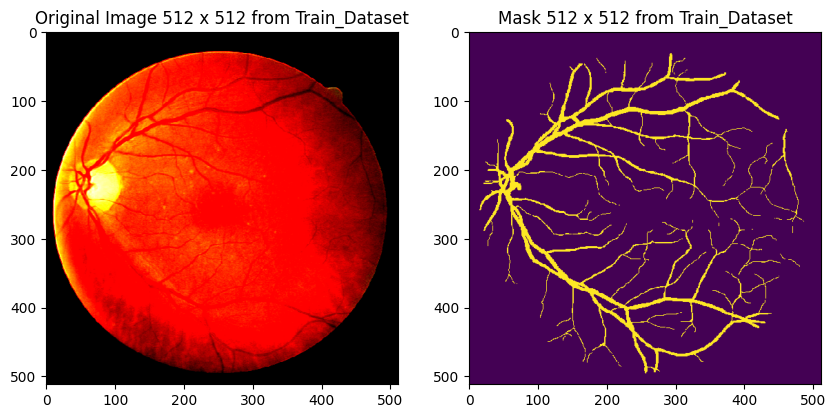

In [12]:
img,mask=train_dataset[0]

print("Image Shape:",img.shape,"Mask Shape:",mask.shape,"Image dtype:",img.dtype, "Mask dtype:", mask.dtype)
print("Unique in Mask:",np.unique(mask))

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title("Original Image 512 x 512 from Train_Dataset")
plt.imshow(torch.permute(img,(1,2,0)))

plt.subplot(1,2,2)
plt.title("Mask 512 x 512 from Train_Dataset")
plt.imshow(mask)
plt.show()

In [13]:
class Unet(nn.Module):
    def __init__(self, encoder, center, decoder):
        super().__init__()
        self.encoder=encoder
        self.center=center
        self.decoder=decoder

    def forward(self,x):
        encoder_features_outputs=self.encoder(x)
        center_output=self.center(encoder_features_outputs[-1])
        logits=self.decoder(center_output, encoder_features_outputs)
        return logits

In [14]:
class Encoder(nn.Module):
    def __init__(self,pretrained_network):
        super().__init__()
        self.encoder=pretrained_network

    def forward(self,x):
        encoder_features_outputs=[]
        for layer in self.encoder.features:
                x=layer(x)
                encoder_features_outputs.append(x)

        return encoder_features_outputs

In [15]:
class Center(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(num_features=1024)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(num_features=1024)
        self.relu2 = nn.ReLU()
#         self.drop = nn.Dropout(0.5)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
#         x = self.drop(x)
        return x


In [16]:
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()

        # self.rl = nn.ReLU()
        self.rl = nn.PReLU()
        # self.hs = nn.Hardswish()
        # self.elu = nn.ELU()
#         self.rl = nn.ReLU()
        self.drop = nn.Dropout(0.15)
        self.drop1 = nn.Dropout(0.1)

        self.conv5_up=nn.Conv2d(in_channels=1024,out_channels=512, kernel_size=3,padding=1)
        self.conv5_1=nn.Conv2d(in_channels=1024,out_channels=512, kernel_size=3,padding=1)
        self.bn5_1=nn.BatchNorm2d(num_features=512)
        self.conv5_2=nn.Conv2d(in_channels=512,out_channels=512, kernel_size=3,padding=1)
        self.bn5_2=nn.BatchNorm2d(num_features=512)
        self.conv5_3=nn.Conv2d(in_channels=512,out_channels=512, kernel_size=3,padding=1)
        self.bn5_3=nn.BatchNorm2d(num_features=512)
        self.conv5_4=nn.Conv2d(in_channels=512,out_channels=512,kernel_size=3,padding=1)
        self.bn5_4 = nn.BatchNorm2d(num_features=512)

        self.conv4_up=nn.Conv2d(in_channels=512,out_channels=512, kernel_size=3,padding=1)
        self.conv4_1=nn.Conv2d(in_channels=1024,out_channels=512, kernel_size=3,padding=1)
        self.bn4_1=nn.BatchNorm2d(num_features=512)
        self.conv4_2=nn.Conv2d(in_channels=512,out_channels=512, kernel_size=3,padding=1)
        self.bn4_2=nn.BatchNorm2d(num_features=512)
        self.conv4_3=nn.Conv2d(in_channels=512,out_channels=512, kernel_size=3,padding=1)
        self.bn4_3=nn.BatchNorm2d(num_features=512)
        self.conv4_4=nn.Conv2d(in_channels=512,out_channels=512,kernel_size=3,padding=1)
        self.bn4_4 = nn.BatchNorm2d(num_features=512)

        self.conv3_up=nn.Conv2d(in_channels=512,out_channels=256, kernel_size=3,padding=1)
        self.conv3_1=nn.Conv2d(in_channels=512,out_channels=256, kernel_size=3,padding=1)
        self.bn3_1=nn.BatchNorm2d(num_features=256)
        self.conv3_2=nn.Conv2d(in_channels=256,out_channels=256, kernel_size=3,padding=1)
        self.bn3_2=nn.BatchNorm2d(num_features=256)
        self.conv3_3=nn.Conv2d(in_channels=256,out_channels=256, kernel_size=3,padding=1)
        self.bn3_3=nn.BatchNorm2d(num_features=256)
        self.conv3_4=nn.Conv2d(in_channels=256,out_channels=256,kernel_size=3,padding=1)
        self.bn3_4 = nn.BatchNorm2d(num_features=256)

        self.conv2_up=nn.Conv2d(in_channels=256,out_channels=128, kernel_size=3,padding=1)
        self.conv2_1=nn.Conv2d(in_channels=256,out_channels=128, kernel_size=3,padding=1)
        self.bn2_1=nn.BatchNorm2d(num_features=128)
        self.conv2_2=nn.Conv2d(in_channels=128,out_channels=128, kernel_size=3,padding=1)
        self.bn2_2=nn.BatchNorm2d(num_features=128)

        self.conv1_up=nn.Conv2d(in_channels=128,out_channels=64, kernel_size=3,padding=1)
        self.conv1_1=nn.Conv2d(in_channels=128,out_channels=64, kernel_size=3,padding=1)
        self.bn1_1=nn.BatchNorm2d(num_features=64)
        self.conv1_2=nn.Conv2d(in_channels=64,out_channels=64, kernel_size=3,padding=1)
        self.bn1_2=nn.BatchNorm2d(num_features=64)

        self.convfinal=nn.Conv2d(in_channels=64,out_channels=2,kernel_size=1)

    def forward(self,x, encoder_features_output):
        x=F.interpolate(x,scale_factor=2, mode="nearest")
        x=self.conv5_up(x)
        x=self.rl(x)
        x=torch.cat((x,encoder_features_output[51]),dim=1)
        x=self.conv5_1(x)
        x=self.bn5_1(x)
        x=self.rl(x)
        x=self.conv5_2(x)
        x=self.bn5_2(x)
        x=self.rl(x)
#         x=self.drop(x)
        x=self.conv5_3(x)
        x=self.bn5_3(x)
        x=self.rl(x)
        x=self.drop1(x)
        x=self.conv5_4(x)
        x=self.bn5_4(x)
        x=self.rl(x)
        x = self.drop(x)

        x=F.interpolate(x,scale_factor=2, mode="nearest")
        x=self.conv4_up(x)
        x=self.rl(x)
        x=torch.cat((x,encoder_features_output[38]),dim=1)
        x=self.conv4_1(x)
        x=self.bn4_1(x)
        x=self.rl(x)
        x=self.conv4_2(x)
        x=self.bn4_2(x)
        x=self.rl(x)
#         x=self.drop1(x)
        x=self.conv4_3(x)
        x=self.bn4_3(x)
        x=self.rl(x)
        x=self.drop1(x)
        x=self.conv4_4(x)
        x=self.bn4_4(x)
        x=self.rl(x)
        x = self.drop(x)

        x=F.interpolate(x,scale_factor=2, mode="nearest")
        x=self.conv3_up(x)
        x=self.rl(x)
        x=torch.cat((x,encoder_features_output[25]),dim=1)
        x=self.conv3_1(x)
        x=self.bn3_1(x)
        x=self.rl(x)
        x=self.conv3_2(x)
        x=self.bn3_2(x)
        x=self.rl(x)
#         x=self.drop(x)
        x=self.conv3_3(x)
        x=self.bn3_3(x)
        x=self.rl(x)
        x=self.drop1(x)
        x=self.conv3_4(x)
        x=self.bn3_4(x)
        x=self.rl(x)
        x = self.drop(x)

        x=F.interpolate(x,scale_factor=2,mode="nearest")
        x=self.conv2_up(x)
        x=self.rl(x)
        x=torch.cat((x,encoder_features_output[12]),dim=1)
        x=self.conv2_1(x)
        x=self.bn2_1(x)
        x=self.rl(x)
        x=self.drop1(x)
        x=self.conv2_2(x)
        x=self.bn2_2(x)
        x=self.rl(x)
#         x = self.drop(x)

        x=F.interpolate(x,scale_factor=2, mode="nearest")
        x=self.conv1_up(x)
        x=self.rl(x)
        x=torch.cat((x,encoder_features_output[5]),dim=1)
        x=self.conv1_1(x)
        x=self.bn1_1(x)
        x=self.rl(x)
        x=self.drop1(x)
        x=self.conv1_2(x)
        x=self.bn1_2(x)
        x=self.rl(x)
#         x = self.drop(x)

        logits=self.convfinal(x)

        return logits

In [17]:
def train_one_epoch(dataloader, model,loss_fn, optimizer):
    model.train()
    track_loss=0
    XintY=0
    X=0
    Y=0
    for i, (imgs, masks) in enumerate(dataloader):
        imgs=imgs.to(device)
        masks=masks.to(device)

        preds=model(imgs)

        loss=loss_fn(preds,masks)

        track_loss+=loss.item()

        predclass=torch.argmax(preds,dim=1)

        Y+=predclass.sum().item()
        X+=masks.sum().item()


        predclass[predclass==0]=2

        XintY+=(predclass==masks).type(torch.float).sum().item()

        print("Trainig Batch",i+1,":","2*XintY:",2*XintY,"X:",X,"Y:",Y, "X+Y:",X+Y)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        running_loss=round(track_loss/(i+1),2)
        running_dice_coef=round(((2*XintY)/(X+Y)),2)

        print("Training Batch", i+1,":","/",len(dataloader), "Running Loss:",running_loss, "Running Dice_Coef:",running_dice_coef)

    epoch_loss=running_loss
    epoch_dice_coef=running_dice_coef
    return epoch_loss, epoch_dice_coef


def val_one_epoch(dataloader, model,loss_fn):
    model.eval()
    track_loss=0
    XintY=0
    X=0
    Y=0
    with torch.no_grad():
        for i, (imgs, masks) in enumerate(dataloader):
            imgs=imgs.to(device)
            masks=masks.to(device)

            preds=model(imgs)

            loss=loss_fn(preds,masks)

            track_loss+=loss.item()

            predclass=torch.argmax(preds,dim=1)

            Y+=predclass.sum().item()
            X+=masks.sum().item()

            predclass[predclass==0]=2

            XintY+=(predclass==masks).type(torch.float).sum().item()

            print("Validation Batch",i+1,":","2*XintY:",2*XintY,"X:",X,"Y:",Y, "X+Y:",X+Y)


            running_loss=round(track_loss/(i+1),2)
            running_dice_coef=round(((2*XintY)/(X+Y)),2)

            print("Validation Batch", i+1,":","/",len(dataloader), "Running Loss:",running_loss, "Running Dice_Coef:",running_dice_coef)

    epoch_loss=running_loss
    epoch_dice_coef=running_dice_coef
    return epoch_loss, epoch_dice_coef

In [18]:
pretrained_network=vgg19_bn(weights=VGG19_BN_Weights.DEFAULT)

for param in pretrained_network.features.parameters():
    param.requires_grad=False

encoder=Encoder(pretrained_network).to(device)
center=Center().to(device)
decoder=Decoder().to(device)

model=Unet(encoder,center, decoder).to(device)

loss_fn=nn.CrossEntropyLoss()

# lr=0.0012
# lr = 0.0029
lr = 0.001

n_epochs = 50
optm = optim.Adam(model.parameters(), lr=lr,weight_decay=1e-4)

scheduler = optim.lr_scheduler.StepLR(optm, step_size=5, gamma=0.97)
# scheduler = optim.lr_scheduler.OneCycleLR(optm,lr,epochs=n_epochs,
                                            # steps_per_epoch=len(train_dataloader))



for i in range(n_epochs):
    print("Epoch No:",i+1)
    train_epoch_loss, train_epoch_dice_coef=train_one_epoch(train_dl,model,loss_fn,optm)
    print("Training Epoch Loss:", train_epoch_loss, "Training Epoch Dice_Coef:", train_epoch_dice_coef)
    val_epoch_loss, val_epoch_dice_coef=val_one_epoch(val_dl,model,loss_fn)
    print("Validation Epoch Loss:", val_epoch_loss, "Validation Epoch Dice_Coef:", val_epoch_dice_coef)
    print("--------------------------------------------------")


for param in pretrained_network.features.parameters():
    param.requires_grad=True

n_epochs= 50

for i in range(n_epochs):
    print("Epoch No:",i+1)
    train_epoch_loss, train_epoch_dice_coef=train_one_epoch(train_dl,model,loss_fn,optm)
    print("Training Epoch Loss:", train_epoch_loss, "Training Epoch Dice_Coef:", train_epoch_dice_coef)
    val_epoch_loss, val_epoch_dice_coef=val_one_epoch(val_dl,model,loss_fn)
    print("Validation Epoch Loss:", val_epoch_loss, "Validation Epoch Dice_Coef:", val_epoch_dice_coef)
    print("--------------------------------------------------")


Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to /root/.cache/torch/hub/checkpoints/vgg19_bn-c79401a0.pth


100%|██████████| 548M/548M [00:07<00:00, 75.1MB/s]


Epoch No: 1
Trainig Batch 1 : 2*XintY: 113068.0 X: 81673 Y: 553126 X+Y: 634799
Training Batch 1 : / 4 Running Loss: 0.74 Running Dice_Coef: 0.18
Trainig Batch 2 : 2*XintY: 283742.0 X: 179722 Y: 1038414 X+Y: 1218136
Training Batch 2 : / 4 Running Loss: 0.69 Running Dice_Coef: 0.23
Trainig Batch 3 : 2*XintY: 433154.0 X: 267216 Y: 1409822 X+Y: 1677038
Training Batch 3 : / 4 Running Loss: 0.67 Running Dice_Coef: 0.26
Trainig Batch 4 : 2*XintY: 587562.0 X: 364581 Y: 1643456 X+Y: 2008037
Training Batch 4 : / 4 Running Loss: 0.64 Running Dice_Coef: 0.29
Training Epoch Loss: 0.64 Training Epoch Dice_Coef: 0.29
Validation Batch 1 : 2*XintY: 161510.0 X: 88013 Y: 916949 X+Y: 1004962
Validation Batch 1 : / 1 Running Loss: 41.89 Running Dice_Coef: 0.16
Validation Epoch Loss: 41.89 Validation Epoch Dice_Coef: 0.16
--------------------------------------------------
Epoch No: 2
Trainig Batch 1 : 2*XintY: 148722.0 X: 85528 Y: 218758 X+Y: 304286
Training Batch 1 : / 4 Running Loss: 0.51 Running Dice_Coe

In [19]:
def plotres(img, pred, mask=None):
    img = img.cpu()
    pred = pred.cpu()

    img_mean = torch.tensor([0.485, 0.456, 0.406]).reshape(3, 1, 1)
    img_std = torch.tensor([0.229, 0.224, 0.225]).reshape(3, 1, 1)
    img = img * img_std + img_mean

    print(f"Image Shape: {img.shape}, Pred Shape: {pred.shape}, Image dtype: {img.dtype}, Pred dtype: {pred.dtype}")
    print(f"Pred Unique: {pred.unique()}")

    plt.figure(figsize=(10, 5))

    plt.subplot(1, 3, 1)
    plt.title("Original Image 512 x 512")
    plt.imshow(img.permute(1, 2, 0))

    if mask is not None:
        mask = mask.cpu()
        print(f"Mask Shape: {mask.shape}, Mask dtype: {mask.dtype}")
        print(f"Mask Unique: {mask.unique()}")
        plt.subplot(1, 3, 2)
        plt.title("Mask Image 512 x 512")
        plt.imshow(mask)

    plt.subplot(1, 3, 3)
    plt.title("Predicted Image 512 x 512")
    plt.imshow(pred)

    plt.show()


On Validation Set: 2*XintY: 143096.0 X: 88013 Y: 87229 X+Y: 175242
Validation Dice Coef: 0.82
Image Shape: torch.Size([3, 512, 512]), Pred Shape: torch.Size([512, 512]), Image dtype: torch.float32, Pred dtype: torch.int64
Pred Unique: tensor([0, 1])
Mask Shape: torch.Size([512, 512]), Mask dtype: torch.int64
Mask Unique: tensor([0, 1])


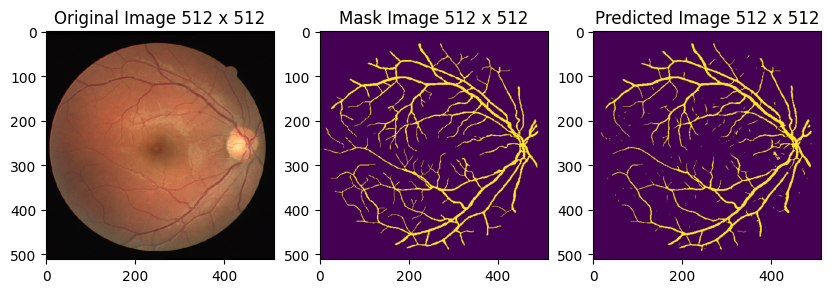

Image Shape: torch.Size([3, 512, 512]), Pred Shape: torch.Size([512, 512]), Image dtype: torch.float32, Pred dtype: torch.int64
Pred Unique: tensor([0, 1])
Mask Shape: torch.Size([512, 512]), Mask dtype: torch.int64
Mask Unique: tensor([0, 1])


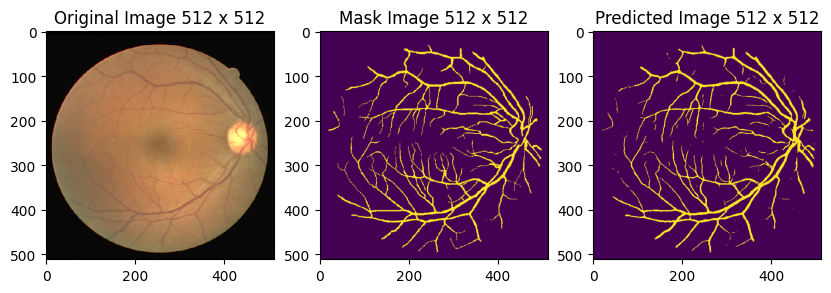

Image Shape: torch.Size([3, 512, 512]), Pred Shape: torch.Size([512, 512]), Image dtype: torch.float32, Pred dtype: torch.int64
Pred Unique: tensor([0, 1])
Mask Shape: torch.Size([512, 512]), Mask dtype: torch.int64
Mask Unique: tensor([0, 1])


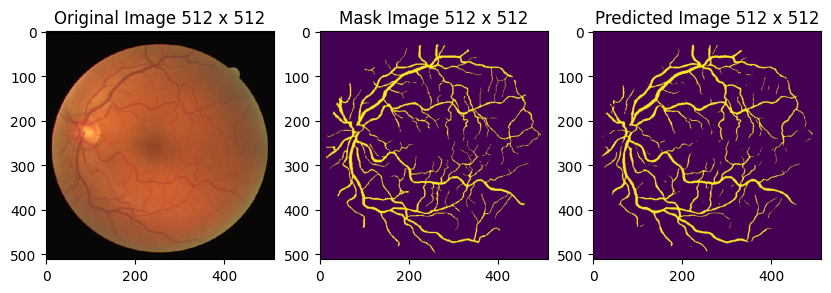

Image Shape: torch.Size([3, 512, 512]), Pred Shape: torch.Size([512, 512]), Image dtype: torch.float32, Pred dtype: torch.int64
Pred Unique: tensor([0, 1])
Mask Shape: torch.Size([512, 512]), Mask dtype: torch.int64
Mask Unique: tensor([0, 1])


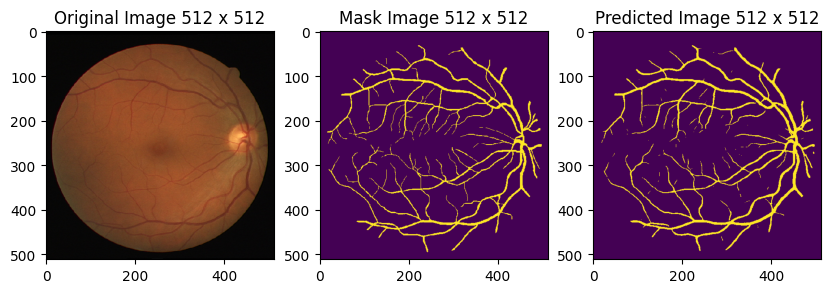

In [20]:
imgs,masks=next(iter(val_dl))
model.eval()

imgs=imgs.to(device)
masks=masks.to(device)

with torch.no_grad():
    preds=model(imgs)

    predclass=torch.argmax(preds,dim=1)

    Y=predclass.sum().item()
    X=masks.sum().item()

    predclass[predclass==0]=2

    XintY=(predclass==masks).type(torch.float).sum().item()

    print("On Validation Set:","2*XintY:",2*XintY,"X:",X,"Y:",Y, "X+Y:",X+Y)

    dice_coef=round((2*XintY)/(X+Y),2)


print("Validation Dice Coef:",dice_coef)

predclass[predclass==2]=0


for i in range(4):
    plotres(imgs[i],predclass[i],masks[i])


In [21]:
train_dataset=TrainDataset("/content/drive/MyDrive/all/train/", "yes")

batch_size=4

n_epochs= 50

train_dataloader=DataLoader(dataset=train_dataset,batch_size=batch_size,shuffle=True)

for i in range(n_epochs):
    print("Epoch No:",i+1)
    train_epoch_loss, train_epoch_dice_coef=train_one_epoch(train_dataloader,model,loss_fn,optm)
    print("Training Epoch Loss:", train_epoch_loss, "Training Epoch Dice_Coef:", train_epoch_dice_coef)
    print("--------------------------------------------------")

Epoch No: 1
Trainig Batch 1 : 2*XintY: 158416.0 X: 100196 Y: 86220 X+Y: 186416
Training Batch 1 : / 4 Running Loss: 0.06 Running Dice_Coef: 0.85
Trainig Batch 2 : 2*XintY: 307608.0 X: 186658 Y: 174396 X+Y: 361054
Training Batch 2 : / 4 Running Loss: 0.06 Running Dice_Coef: 0.85
Trainig Batch 3 : 2*XintY: 464894.0 X: 279772 Y: 265954 X+Y: 545726
Training Batch 3 : / 4 Running Loss: 0.06 Running Dice_Coef: 0.85
Trainig Batch 4 : 2*XintY: 615796.0 X: 364581 Y: 355754 X+Y: 720335
Training Batch 4 : / 4 Running Loss: 0.06 Running Dice_Coef: 0.85
Training Epoch Loss: 0.06 Training Epoch Dice_Coef: 0.85
--------------------------------------------------
Epoch No: 2
Trainig Batch 1 : 2*XintY: 159078.0 X: 95432 Y: 86816 X+Y: 182248
Training Batch 1 : / 4 Running Loss: 0.05 Running Dice_Coef: 0.87
Trainig Batch 2 : 2*XintY: 306532.0 X: 186286 Y: 168976 X+Y: 355262
Training Batch 2 : / 4 Running Loss: 0.06 Running Dice_Coef: 0.86
Trainig Batch 3 : 2*XintY: 447712.0 X: 269856 Y: 251489 X+Y: 521345

In [22]:
class TestDataset(Dataset):
    def __init__(self,path):
        super().__init__()
        self.path=path
        _,_,self.filepaths=next(os.walk(path))
        self.length=len(self.filepaths)
        self.transform=Compose([ToTensor(), Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])])

    def __len__(self):
        return self.length

    def __getitem__(self,idx):
        idx=idx+1
        if idx <= 9:
            path=self.path + "0" + str(idx) + "_test.tif"
        else:
            path=self.path + str(idx) + "_test.tif"

        img=reshape_to_512(path)
        img=self.transform(img)

        return img

In [23]:
test_dataset=TestDataset("/content/drive/MyDrive/all/test/")

batch_size=2
test_dataloader=DataLoader(dataset=test_dataset,batch_size=batch_size)

Image Shape: torch.Size([3, 512, 512]), Pred Shape: torch.Size([512, 512]), Image dtype: torch.float32, Pred dtype: torch.int64
Pred Unique: tensor([0, 1])


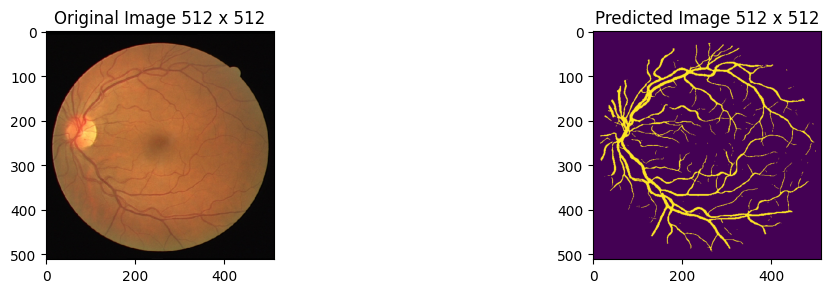

Image Shape: torch.Size([3, 512, 512]), Pred Shape: torch.Size([512, 512]), Image dtype: torch.float32, Pred dtype: torch.int64
Pred Unique: tensor([0, 1])


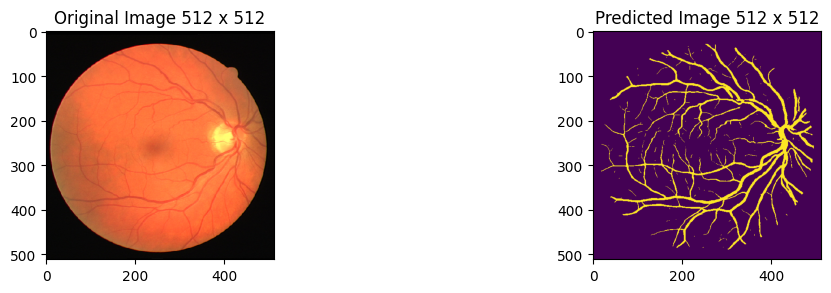

Image Shape: torch.Size([3, 512, 512]), Pred Shape: torch.Size([512, 512]), Image dtype: torch.float32, Pred dtype: torch.int64
Pred Unique: tensor([0, 1])


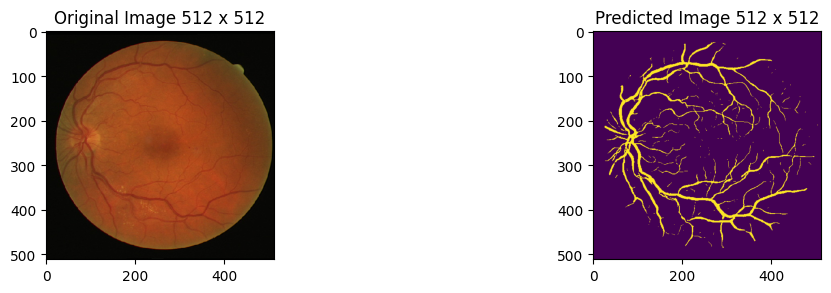

Image Shape: torch.Size([3, 512, 512]), Pred Shape: torch.Size([512, 512]), Image dtype: torch.float32, Pred dtype: torch.int64
Pred Unique: tensor([0, 1])


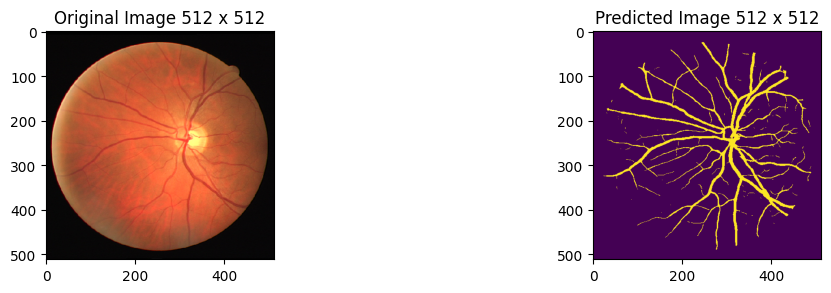

Image Shape: torch.Size([3, 512, 512]), Pred Shape: torch.Size([512, 512]), Image dtype: torch.float32, Pred dtype: torch.int64
Pred Unique: tensor([0, 1])


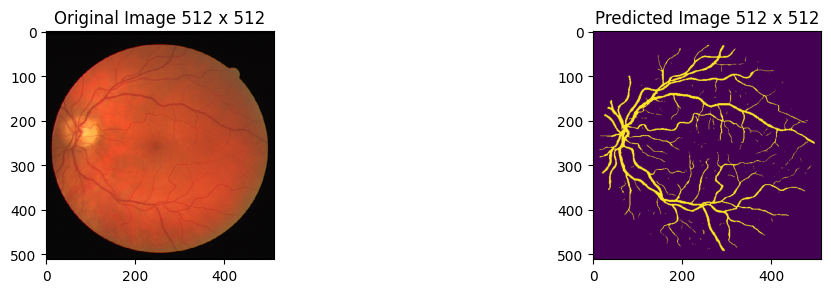

Image Shape: torch.Size([3, 512, 512]), Pred Shape: torch.Size([512, 512]), Image dtype: torch.float32, Pred dtype: torch.int64
Pred Unique: tensor([0, 1])


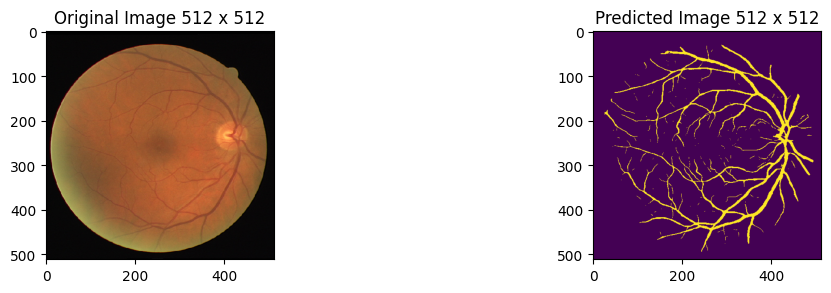

Image Shape: torch.Size([3, 512, 512]), Pred Shape: torch.Size([512, 512]), Image dtype: torch.float32, Pred dtype: torch.int64
Pred Unique: tensor([0, 1])


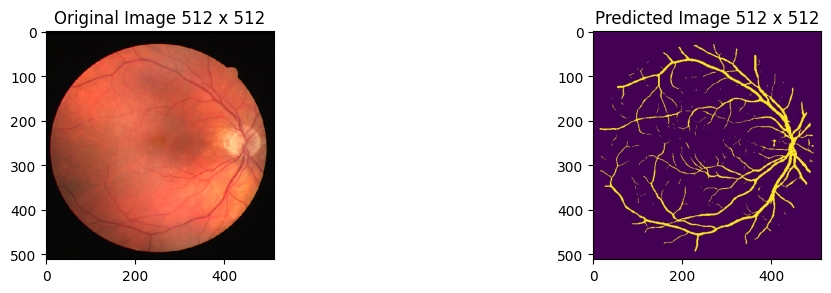

Image Shape: torch.Size([3, 512, 512]), Pred Shape: torch.Size([512, 512]), Image dtype: torch.float32, Pred dtype: torch.int64
Pred Unique: tensor([0, 1])


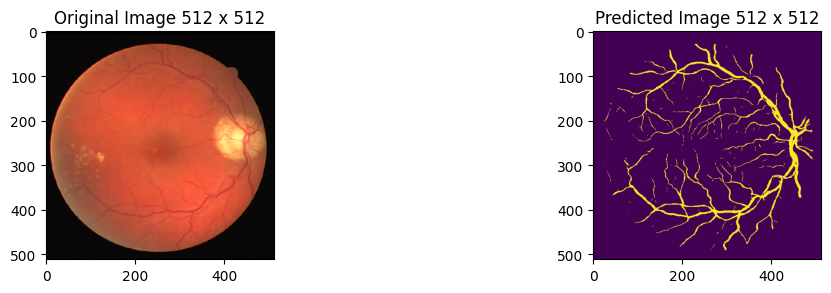

Image Shape: torch.Size([3, 512, 512]), Pred Shape: torch.Size([512, 512]), Image dtype: torch.float32, Pred dtype: torch.int64
Pred Unique: tensor([0, 1])


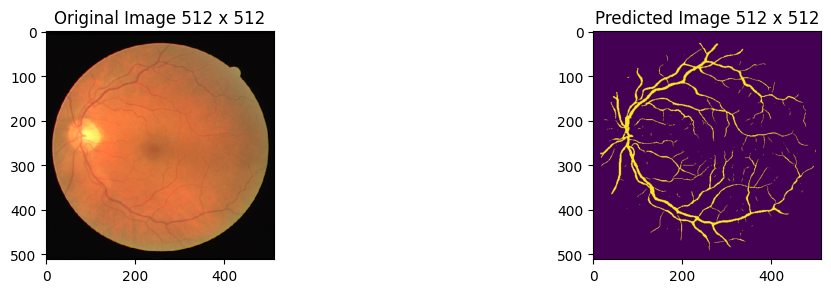

Image Shape: torch.Size([3, 512, 512]), Pred Shape: torch.Size([512, 512]), Image dtype: torch.float32, Pred dtype: torch.int64
Pred Unique: tensor([0, 1])


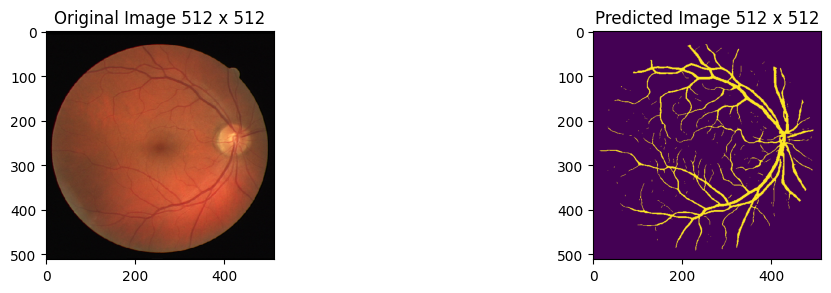

Image Shape: torch.Size([3, 512, 512]), Pred Shape: torch.Size([512, 512]), Image dtype: torch.float32, Pred dtype: torch.int64
Pred Unique: tensor([0, 1])


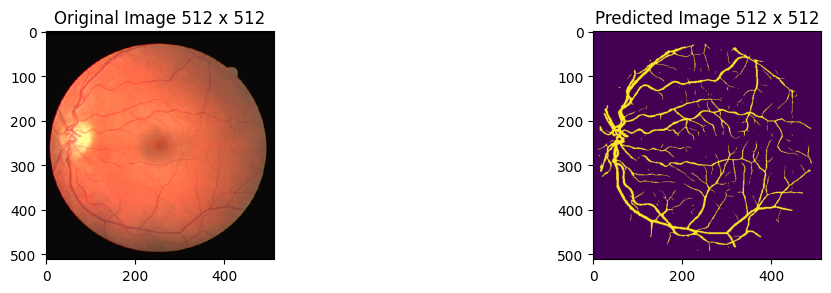

Image Shape: torch.Size([3, 512, 512]), Pred Shape: torch.Size([512, 512]), Image dtype: torch.float32, Pred dtype: torch.int64
Pred Unique: tensor([0, 1])


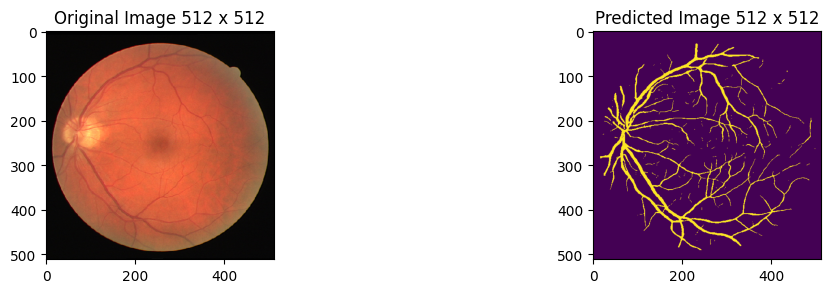

Image Shape: torch.Size([3, 512, 512]), Pred Shape: torch.Size([512, 512]), Image dtype: torch.float32, Pred dtype: torch.int64
Pred Unique: tensor([0, 1])


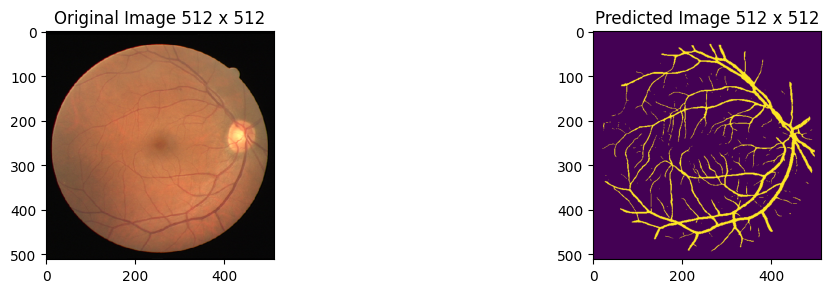

Image Shape: torch.Size([3, 512, 512]), Pred Shape: torch.Size([512, 512]), Image dtype: torch.float32, Pred dtype: torch.int64
Pred Unique: tensor([0, 1])


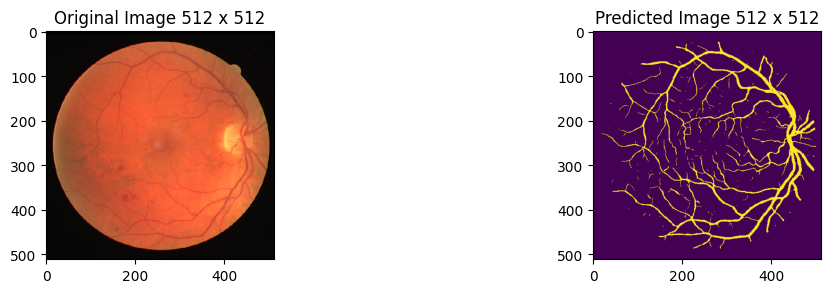

Image Shape: torch.Size([3, 512, 512]), Pred Shape: torch.Size([512, 512]), Image dtype: torch.float32, Pred dtype: torch.int64
Pred Unique: tensor([0, 1])


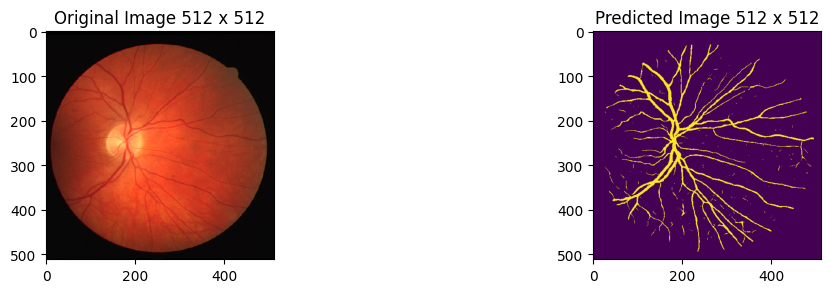

Image Shape: torch.Size([3, 512, 512]), Pred Shape: torch.Size([512, 512]), Image dtype: torch.float32, Pred dtype: torch.int64
Pred Unique: tensor([0, 1])


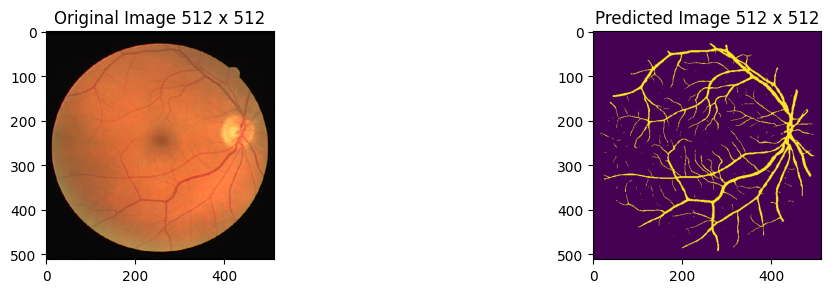

Image Shape: torch.Size([3, 512, 512]), Pred Shape: torch.Size([512, 512]), Image dtype: torch.float32, Pred dtype: torch.int64
Pred Unique: tensor([0, 1])


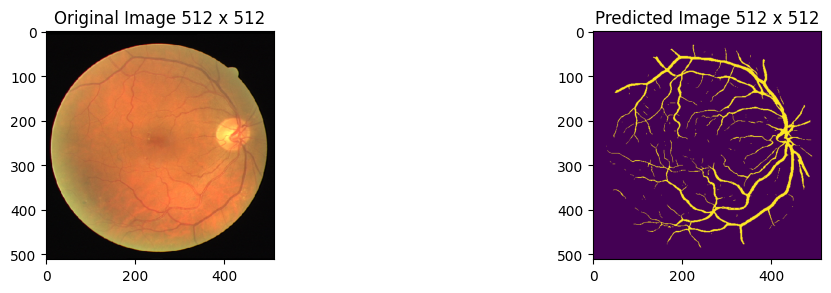

Image Shape: torch.Size([3, 512, 512]), Pred Shape: torch.Size([512, 512]), Image dtype: torch.float32, Pred dtype: torch.int64
Pred Unique: tensor([0, 1])


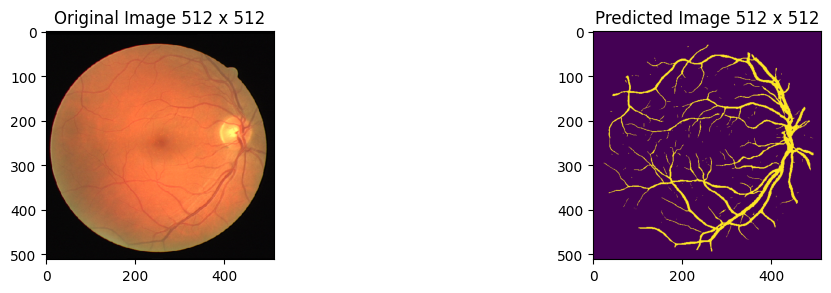

Image Shape: torch.Size([3, 512, 512]), Pred Shape: torch.Size([512, 512]), Image dtype: torch.float32, Pred dtype: torch.int64
Pred Unique: tensor([0, 1])


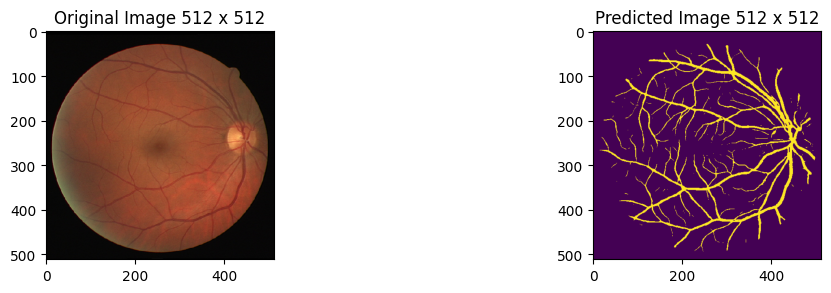

Image Shape: torch.Size([3, 512, 512]), Pred Shape: torch.Size([512, 512]), Image dtype: torch.float32, Pred dtype: torch.int64
Pred Unique: tensor([0, 1])


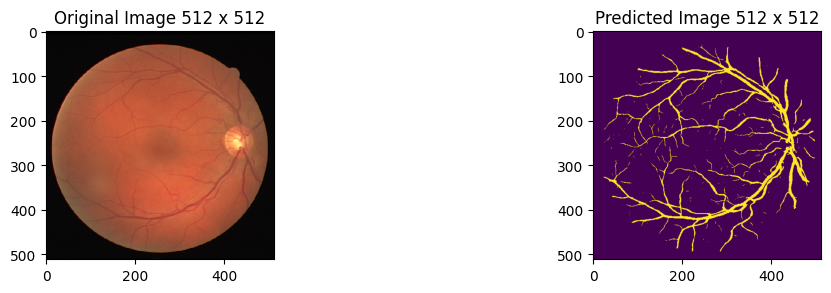

Id                                          Predicted
0    0  14084 5 14596 4 15109 2 15621 2 15652 2 16104 ...
1    1  15101 6 15614 7 15635 1 16128 6 16147 2 16641 ...
2    2  13071 5 13578 7 14090 4 14116 2 14543 1 14601 ...
3    3  13045 5 13557 6 14069 7 14582 6 15095 6 15152 ...
4    4  16131 2 16641 5 16676 4 17153 4 17187 5 17664 ...
5    5  16161 2 16674 4 17152 1 17186 5 17664 1 17699 ...
6    6  15631 2 16103 2 16143 3 16611 8 16655 3 17123 ...
7    7  15078 5 15121 3 15589 6 15633 4 16103 5 16145 ...
8    8  14063 4 14575 5 14614 3 15089 3 15125 5 15602 ...
9    9  15613 4 16089 3 16127 3 16599 6 16640 2 17109 ...
10  10  15100 3 15587 1 15612 3 16096 4 16124 4 16607 ...
11  11  14568 3 15079 5 15129 2 15591 5 15640 3 16103 ...
12  12  15111 3 15622 5 16135 4 16155 5 16606 5 16647 ...
13  13  12569 3 13082 3 13535 2 13593 5 14106 4 14618 ...
14  14  15624 2 16093 3 16136 2 16153 2 16605 3 16647 ...
15  15  14598 6 15111 6 15624 6 16137 7 16170 4 16651 ...
16  16  16097 3 16609 3 17121 2 17633 2 18145 2 18657 ...
17  17  16129 4 16641 3 17152 3 17622 2 17664 2 18133 ...
18  18  15104 3 15616 4 16128 5 16641 5 16684 4 17154 ...
19  19  16629 1 17141 1 17653 1 18158 1 18165 1 18673 ...

In [24]:
def eval_one_epoch(dataloader, model):
    model.eval()
    outputs=[]
    for i, imgs in enumerate(dataloader):
        imgs=imgs.to(device)
        preds=model(imgs)

        with torch.no_grad():
            for i in range(preds.shape[0]):
                pred=preds[i,:,:,:]
                pred=torch.argmax(pred,dim=0).cpu()

                plotres(imgs[i],pred)

                predf=pred.flatten()

                pixelidx=np.where(predf==1)[0]+1

                run_lengths=[]

                for pxid in pixelidx:
                    if len(run_lengths)==0:
                        run_lengths.extend((pxid,1))
                    elif pxid>prev+1:
                        run_lengths.extend((pxid,1))
                    else:
                        run_lengths[-1]+=1
                    prev=pxid

                output = ' '.join([str(r) for r in run_lengths])

                outputs.append(output)
    return outputs

outputs=eval_one_epoch(test_dataloader,model)
df=pd.DataFrame(columns=['Id','Predicted'])
df['Id']=[str(i) for i in range(20)]
df['Predicted']=outputs
df.to_csv("submission.csv", index=None)
df

In [25]:
from google.colab import files
files.download("submission.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>